In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost

import torch
import beacon

-----------
Data Loading and Visualisation
---------

In [29]:
KMU2GIB_EVENT_COUNT = 20000
KMU2GSDINT_RATIO = 0.0419
K2PI_RATIO = 33.3387
KMU3_RATIO = 5.4048

In [30]:
matplotlib.rcParams['figure.figsize'] = (9, 6)
# plt.style.use('dark_background')

In [31]:
def read_dir(directory):
    # Initialize an empty list to store the dataframes
    dfs = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            # Read the CSV file into a dataframe
            filepath = os.path.join(directory, filename)
            try:
                df = pd.read_csv(filepath)
            except:
                print(f'Error reading {filepath}')
                continue
            
            # Append the dataframe to the list
            dfs.append(df)

    # Concatenate all dataframes into one
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [32]:
kmu2gib_df = read_dir("/eos/user/y/yuanye/Analysis/data/run2/kmu2gibdata")
kmu2gsd_df = read_dir("/eos/user/y/yuanye/Analysis/data/run2/kmu2gsddata")
kmu2gintm_df = read_dir("/eos/user/y/yuanye/Analysis/data/run2/kmu2gintmdata")
k2pi_df = read_dir("/eos/user/y/yuanye/Analysis/data/run2/k2pidata")
kmu3_df = read_dir("/eos/user/y/yuanye/Analysis/data/run2/kmu3data")

Error reading /eos/user/y/yuanye/Analysis/data/run2/k2pidata/out1.csv
Error reading /eos/user/y/yuanye/Analysis/data/run2/k2pidata/out17.csv
Error reading /eos/user/y/yuanye/Analysis/data/run2/k2pidata/out18.csv
Error reading /eos/user/y/yuanye/Analysis/data/run2/k2pidata/out2.csv
Error reading /eos/user/y/yuanye/Analysis/data/run2/k2pidata/out21.csv
Error reading /eos/user/y/yuanye/Analysis/data/run2/k2pidata/out24.csv
Error reading /eos/user/y/yuanye/Analysis/data/run2/k2pidata/out3.csv
Error reading /eos/user/y/yuanye/Analysis/data/run2/k2pidata/out32.csv
Error reading /eos/user/y/yuanye/Analysis/data/run2/k2pidata/out4.csv
Error reading /eos/user/y/yuanye/Analysis/data/run2/k2pidata/out6.csv
Error reading /eos/user/y/yuanye/Analysis/data/run2/k2pidata/out9.csv


In [33]:
k2pi_df['CumulativeEventCount'] = k2pi_df['EventCount'].cumsum()
kmu3_df['CumulativeEventCount'] = kmu3_df['EventCount'].cumsum()
kmu2gsd_df['CumulativeEventCount'] = kmu2gsd_df['EventCount'].cumsum()
kmu2gintm_df['CumulativeEventCount'] = kmu2gintm_df['EventCount'].cumsum()
kmu2gib_df['CumulativeEventCount'] = kmu2gib_df['EventCount'].cumsum()

In [34]:
k2pi_df["CumulativeEventCount"].max(), kmu3_df["CumulativeEventCount"].max()

(1490569, 7033119)

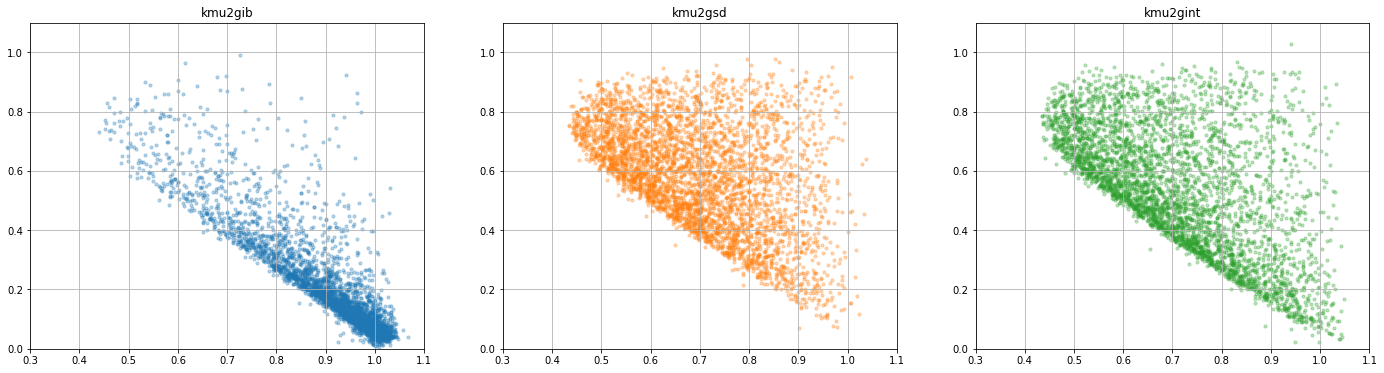

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
ax[0].scatter(kmu2gib_df["XMu"], kmu2gib_df["XGamma"], s=10, alpha=0.3, c="C0")
ax[0].set_xlim(0.3, 1.1)
ax[0].set_ylim(0, 1.1)
ax[0].grid()
ax[1].scatter(kmu2gsd_df["XMu"], kmu2gsd_df["XGamma"], s=10, alpha=0.3, c="C1")
ax[1].set_xlim(0.3, 1.1)
ax[1].set_ylim(0, 1.1)
ax[1].grid()
ax[2].scatter(kmu2gintm_df["XMu"], kmu2gintm_df["XGamma"], s=10, alpha=0.3, c="C2")
ax[2].set_xlim(0.3, 1.1)
ax[2].set_ylim(0, 1.1)
ax[2].grid()
ax[0].title.set_text('kmu2gib')
ax[1].title.set_text("kmu2gsd")
ax[2].title.set_text("kmu2gint")
plt.show()

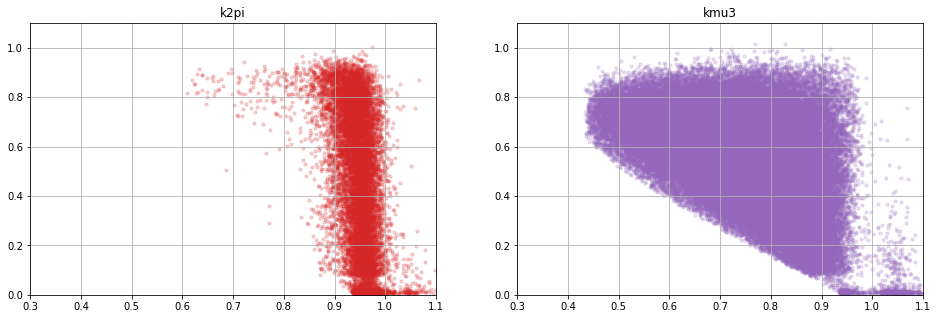

In [36]:
fig2, ax2 = plt.subplots(1, 2, figsize=(16, 5))
ax2[0].scatter(k2pi_df["XMu"], k2pi_df["XGamma"], s=10, alpha=0.2, c="C3")
ax2[0].set_xlim(0.3, 1.1)
ax2[0].set_ylim(0, 1.1)
ax2[0].grid()
ax2[1].scatter(kmu3_df["XMu"], kmu3_df["XGamma"], s=10, alpha=0.2, c="C4")
ax2[1].set_xlim(0.3, 1.1)
ax2[1].set_ylim(0, 1.1)
ax2[1].grid()
ax2[0].title.set_text('k2pi')
ax2[1].title.set_text("kmu3")
plt.show()

In [37]:
kmu2gsd_df_sub = kmu2gsd_df[kmu2gsd_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * (KMU2GSDINT_RATIO/2)]
kmu2gintm_df_sub = kmu2gintm_df[kmu2gintm_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * (KMU2GSDINT_RATIO/2)]
kmu2gsdintm_df_sub = pd.concat([kmu2gsd_df_sub, kmu2gintm_df_sub], ignore_index=True)
k2pi_df_sub = k2pi_df[k2pi_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * K2PI_RATIO]
kmu3_df_sub = kmu3_df[kmu3_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * KMU3_RATIO]

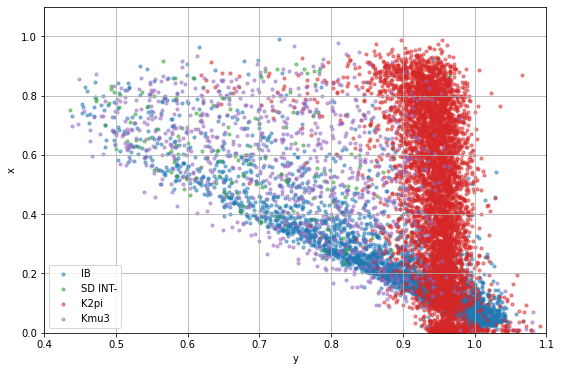

In [38]:
plt.scatter(kmu2gib_df["XMu"], kmu2gib_df["XGamma"], s=10, alpha=0.5, label="IB")
plt.scatter(kmu2gsdintm_df_sub["XMu"], kmu2gsdintm_df_sub["XGamma"], s=10, alpha=0.5, label="SD INT-", c="C2")
plt.scatter(k2pi_df_sub["XMu"], k2pi_df_sub["XGamma"], s=10, alpha=0.5, label="K2pi", c="C3")
plt.scatter(kmu3_df_sub["XMu"], kmu3_df_sub["XGamma"], s=10, alpha=0.5, label="Kmu3", c="C4")
plt.xlim(0.4, 1.1)
plt.ylim(0, 1.1)
plt.xlabel("y")
plt.ylabel("x")
# plt.title("Combined normalised plot")
plt.grid()
plt.legend()
plt.show()

---------
Exploratory Analysis
---------

In [39]:
# calculate the acceptance ratio
kmu2gib_acceptance = len(kmu2gib_df) / KMU2GIB_EVENT_COUNT
kmu2gsd_acceptance = len(kmu2gsd_df) / kmu2gsd_df["CumulativeEventCount"].max()
kmu2gintm_acceptance = len(kmu2gintm_df) / kmu2gintm_df["CumulativeEventCount"].max()
k2pi_acceptance = len(k2pi_df) / k2pi_df["CumulativeEventCount"].max()
kmu3_acceptance = len(kmu3_df) / kmu3_df["CumulativeEventCount"].max()

print("kmu2gib Acceptance: ", kmu2gib_acceptance)
print("kmu2gsd- Acceptance: ", kmu2gsd_acceptance)
print("kmu2gint- Acceptance: ", kmu2gintm_acceptance)
print("k2pi Acceptance: ", k2pi_acceptance)
print("kmu3 Acceptance: ", kmu3_acceptance)

kmu2gib Acceptance:  0.22035
kmu2gsd- Acceptance:  0.20048055263553086
kmu2gint- Acceptance:  0.20490367775831875
k2pi Acceptance:  0.008956982199415122
kmu3 Acceptance:  0.008213710019693964


In [40]:
# Add mode column for classification
# 0: kmu2gib, 1: kmu2gsd, 2: kmu2gintm, 3: k2pi, 4: kmu3
kmu2gib_df["Mode"] = 0
kmu2gsdintm_df_sub["Mode"] = 1
k2pi_df_sub["Mode"] = 2
kmu3_df_sub["Mode"] = 3

combined_df = pd.concat([kmu2gib_df, kmu2gsdintm_df_sub, k2pi_df_sub, kmu3_df_sub], ignore_index=True)
combined_df.head()

/tmp/yuanye/ipykernel_2165668/910201184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k2pi_df_sub["Mode"] = 2
/tmp/yuanye/ipykernel_2165668/910201184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmu3_df_sub["Mode"] = 3


,EventCount,GTKMomentumX,GTKMomentumY,GTKMomentumZ,GTKEnergy,GTKGamma,GTKBeta,NLKrCells,NLKrClusters,LKrClusterEnergy,...,MissingMomentumX,MissingMomentumY,MissingMomentumZ,MissingMassSquared,KaonMass,CDAAfterCut,XGamma,XMu,CumulativeEventCount,Mode
0,2,0.086383,0.006344,74.9367,74.9384,151.795,0.999978,2,2,0.636122,...,-0.002676,-0.192919,0.104368,0.001698,0.489843,5.095640,0.137183,0.958610,2,0
1,2,0.087944,0.004353,74.9970,74.9986,151.918,0.999978,2,2,0.598496,...,-0.025490,0.103667,-0.210818,-0.002465,0.498955,5.476340,0.044741,1.019300,4,0
2,17,0.091698,0.004303,73.8888,73.8905,149.673,0.999978,2,2,0.510163,...,-0.001639,0.224760,-0.052429,0.000242,0.493157,0.364728,0.108892,0.953972,21,0
3,13,0.078475,0.003350,73.7343,73.7360,149.360,0.999978,2,2,0.527540,...,-0.216886,-0.021969,-0.080431,0.000528,0.492548,0.759692,0.058449,0.995625,34,0
4,7,0.098726,-0.001611,74.8016,74.8033,151.522,0.999978,2,2,0.617125,...,0.041496,0.167677,-0.091014,0.000166,0.493254,18.501000,0.314814,0.892479,41,0


In [41]:
combined_df.insert(0, "GTKMomentum", np.sqrt(combined_df["GTKMomentumX"]**2 + combined_df["GTKMomentumY"]**2 + combined_df["GTKMomentumZ"]**2))
combined_df.insert(5, "MuonMomentumPrime", np.sqrt(combined_df["MuonMomentumPrimeX"]**2 + combined_df["MuonMomentumPrimeY"]**2 + combined_df["MuonMomentumPrimeZ"]**2))
combined_df.insert(10, "MissingMomentum", np.sqrt(combined_df["MissingMomentumX"]**2 + combined_df["MissingMomentumY"]**2 + combined_df["MissingMomentumZ"]**2))

In [42]:
# Remove unnecessary columns for classification
combined_df = combined_df.drop(columns=["NLKrCells", "NLKrClusters", "NVertices", "NTracks", "GTKMomentumX", "GTKMomentumY", "GTKMomentumZ", "GTKEnergy", "GTKGamma", "GTKBeta", "EventCount", "GTKMomentumX", "GTKMomentumY", "GTKMomentumZ", "MuonMomentumX", "MuonMomentumY", "MuonMomentumZ", "MuonMomentumPrimeX", "MuonMomentumPrimeY", "MuonMomentumPrimeZ", "MissingMomentumX", "MissingMomentumY", "MissingMomentumZ", "CDAAfterCut", "CumulativeEventCount", "CDA", "TrackTime", "QChi2Track"])

In [43]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11512 entries, 0 to 11511
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GTKMomentum           11512 non-null  float64
 1   MuonMomentumPrime     11512 non-null  float64
 2   MissingMomentum       11512 non-null  float64
 3   LKrClusterEnergy      11512 non-null  float64
 4   EoP                   11512 non-null  float64
 5   MuonTrueEnergy        11512 non-null  float64
 6   MuonLKrClusterEnergy  11512 non-null  float64
 7   MuonEnergyPrime       11512 non-null  float64
 8   PhotonEnergy          11512 non-null  float64
 9   PhotonEnergyPrime     11512 non-null  float64
 10  GammaMuAngle          11512 non-null  float64
 11  CosGammaMuAngle       11512 non-null  float64
 12  MissingEnergy         11512 non-null  float64
 13  MissingMassSquared    11512 non-null  float64
 14  KaonMass              11512 non-null  float64
 15  XGamma             

In [44]:
combined_df.describe()

,GTKMomentum,MuonMomentumPrime,MissingMomentum,LKrClusterEnergy,EoP,MuonTrueEnergy,MuonLKrClusterEnergy,MuonEnergyPrime,PhotonEnergy,PhotonEnergyPrime,GammaMuAngle,CosGammaMuAngle,MissingEnergy,MissingMassSquared,KaonMass,XGamma,XMu,Mode
count,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000
mean,74.842429,0.198424,0.172931,1.368301,0.034834,42.589199,1.368301,0.225481,15.822239,0.087130,1.740309,-0.125781,0.181069,0.002910,0.485542,0.352980,0.913472,1.299687
std,0.815119,0.030736,0.061927,1.762204,0.034661,14.009532,1.762204,0.025278,13.158800,0.068478,0.841131,0.686975,0.062162,0.006152,0.015837,0.277417,0.102407,1.064185
min,68.394434,0.019631,0.004846,0.269148,0.004809,7.190750,0.269148,0.107442,0.274848,0.000978,0.032870,-0.999911,0.014621,-0.020878,0.440030,0.003964,0.435270,0.000000
25%,74.275970,0.195954,0.123330,0.530728,0.013306,31.802825,0.530728,0.222622,4.716260,0.024908,0.975816,-0.827775,0.133488,-0.000487,0.480242,0.100908,0.901886,0.000000
50%,74.858197,0.208452,0.202787,0.575288,0.020010,43.973150,0.575288,0.233679,12.420900,0.069460,1.777285,-0.205027,0.208173,0.000930,0.490674,0.281398,0.946682,2.000000
75%,75.413384,0.214675,0.225278,0.907475,0.037409,54.012125,0.907475,0.239329,24.119725,0.145761,2.545925,0.560492,0.230512,0.003899,0.495097,0.590508,0.969571,2.000000
max,80.616283,0.256674,0.258001,10.475400,0.149971,76.040300,10.475400,0.277473,63.038900,0.244208,3.128220,0.999460,0.260673,0.025053,0.539901,0.989336,1.124100,3.000000


<AxesSubplot:>

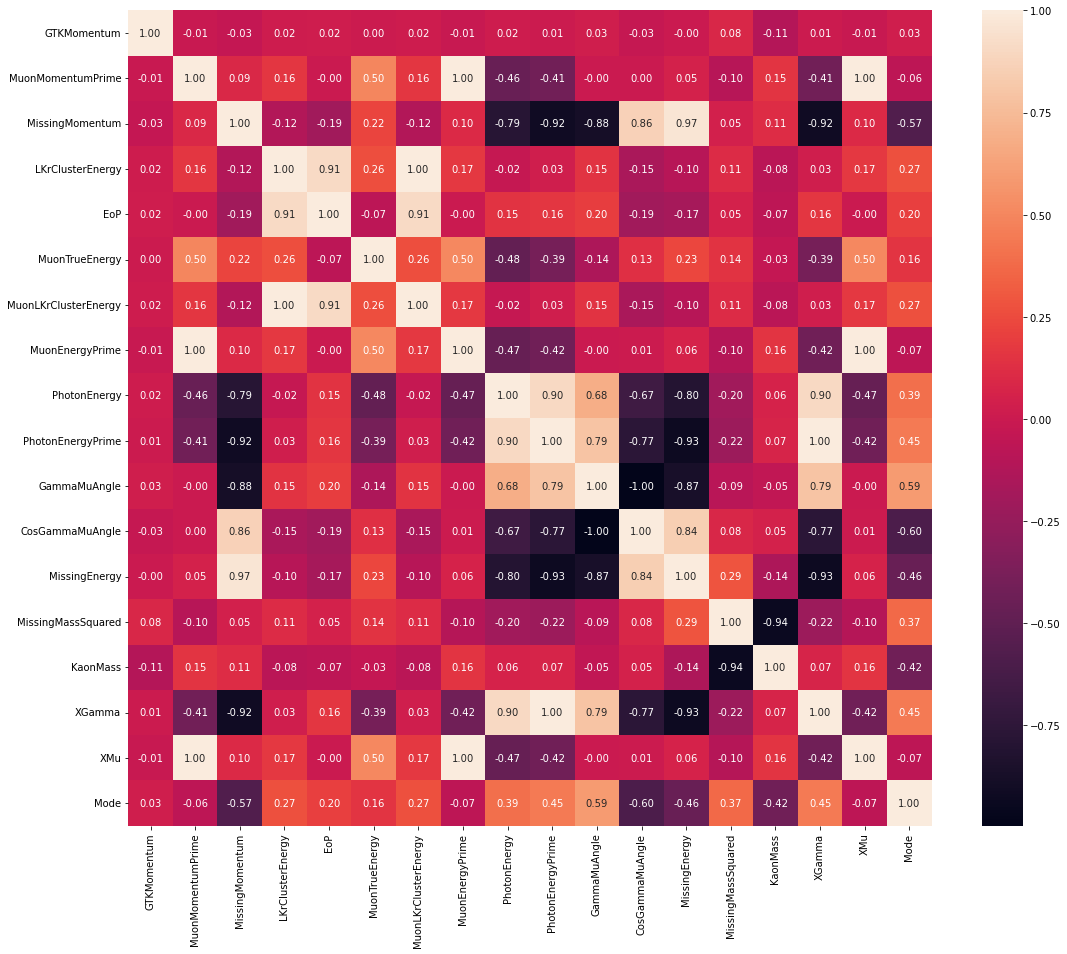

In [45]:
plt.figure(figsize=(18, 15))
sns.heatmap(combined_df.corr(), annot=True, fmt='.2f')

In [46]:
X = combined_df.drop(columns=["Mode"])
y = combined_df["Mode"]

Text(0.5, 1.0, 'Actual Clustering')

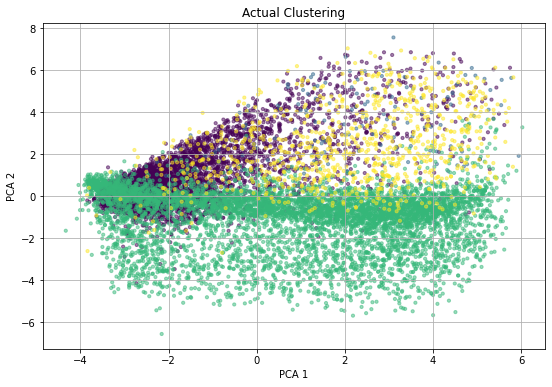

In [47]:
# perform PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=len(X.columns))
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=5)
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=10, alpha=0.5, cmap='viridis')
plt.grid()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Actual Clustering")

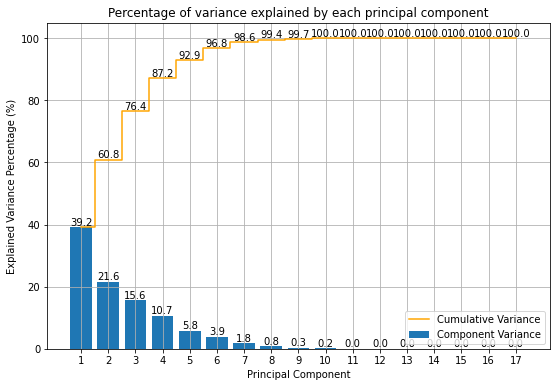

In [48]:
# plotting the principle component variance
plt.bar_label(plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_ * 100, tick_label=range(1, len(pca.explained_variance_ratio_)+1), label="Component Variance"), fmt="%.1f")
# plot the cumulative as a step line
plt.step(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_ * 100), where='mid', color='orange', label="Cumulative Variance")
# assign values on the cumulative line
for i, j in zip(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_ * 100)):
    # the first component and cumulative variance is the same so skip
    if i == 0:
        continue
    plt.text(i, j, f"{j:.1f}", ha='center', va='bottom')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Percentage (%)')
plt.title("Percentage of variance explained by each principal component")
plt.grid()
plt.legend()